## <a id="step0"></a> Step 1: Build, train, and save a model

**About the sample model**

The sample model built here classifies text messages from fictional customers into two categories:
- "social" : The message might just be social and friendly, or the message lacks enough text to perform in-depth analysis
- "problem or question" : The message describes a problem or asks a question

Classifying messages this way is useful for multiple purposes:
- Automating responses (eg. respond to social messages with a generial greeting, prompting the user to type their question or problem if they have one)
- Cleaning out social message for post-hoc analysis

The data used to train the model is the "sample-customer-messages.csv" training data in the IBM Watson Studio community: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744" target="_blank" rel="noopener noreferrer">Customer messages sample data</a>.

### Load and prepare training data

1. Go to the <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744" target="_blank" rel="noopener noreferrer">Customer messages</a> data set in the Watson Studio Gallery.
2. Load the .csv file as a Data Asset in your project by clicking the **Add to Project** button in the upper-right corner of the page. Select your project name and click **Add**. You can now view the data set in your project.
3. Load the Customer messages .csv file into your notebook. Click the Data icon on the notebook action bar. Scroll through your list of assets to find the Customer messages .csv that you added to your project earlier. **Note:** If you can't find the data asset, reload your notebook. To load the data into a DataFrame, click in the next code cell and select **Insert to code > Insert Pandas DataFrame** under the file name.
4. Change `df_data_x = pd.read_csv(body)` to `df = pd.read_csv(body, names=["message", "class_name"])`.
5. Also, change `df_data_1.head()` to `df.head()`.
6. Run the cell.

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_cfd7f49c98274acca568716ce0b8c72a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='rS2X7FJE-NSVZw6sLdgIWaJrG5ZZ_D7qNv7gA2YobxY7',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_cfd7f49c98274acca568716ce0b8c72a.get_object(Bucket='neuralnets-donotdelete-pr-ecfmjholqrxocb',Key='sample-customer-messages.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body, names=["message", "class_name"])
df.head()

,message,class_name
0,excuse me,hi
1,Good evening,hi
2,Good morning,hi
3,good morning,hi
4,Good morning can you help me upload a shapefile?,question


In [2]:
# # Read sample data into Pandas DataFrame
df[6:9]

,message,class_name
6,Greetings :),hi
7,hai how can i do analyze with csv file is ther...,question
8,Having issues setup WML service,problem


In [3]:
# Split the data into training and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
train, test = train_test_split( df, test_size = 0.1 )
test

,message,class_name
70,Hi there,hi
42,Hi cant login today with this err The owners a...,problem
95,jupyter notebook is unable to connect to kernel,problem
78,how do i save my data as a csv file,question
48,Hi I created a csv in my notebook but how do I...,question
79,How do I start using Watson Machine Learning,question
12,hello,hi
59,Hi im having some troubles with a shiny app,problem
10,Hello,hi
14,hello how can i download a csv file from my no...,question


In [4]:
!pip install --upgrade keras==2.2.5

     |████████████████████████████████| 337kB 12.5MB/s eta 0:00:01
     |████████████████████████████████| 51kB 13.0MB/s eta 0:00:01
     |████████████████████████████████| 51kB 15.4MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
  Found existing installation: Keras-Applications 1.0.6
    Uninstalling Keras-Applications-1.0.6:
      Successfully uninstalled Keras-Applications-1.0.6
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [5]:
# Convert words to numbers
# https://keras.io/preprocessing/text/#tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts( train["message"] )
X_train = t.texts_to_sequences( train["message"] )
X_test  = t.texts_to_sequences( test["message"] )
X_test[0:4]

Using TensorFlow backend.


[[3, 23],
 [3, 172, 34, 53, 10, 26, 64, 53, 262, 230],
 [232, 9, 26, 242, 1, 163, 1],
 [5, 43, 2, 7, 18, 4, 51, 36]]

In [6]:
# Pad the shorter entries
# https://keras.io/preprocessing/sequence/#pad_sequences
from keras.preprocessing.sequence import pad_sequences
max_len = max( len(x) for x in X_train )
X_train = pad_sequences( X_train, padding='post', maxlen=max_len )
X_test  = pad_sequences( X_test,  padding='post', maxlen=max_len )
X_test[0]

array([ 3, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [7]:
# Convert the labels to binary labels
import scipy
import numpy as np
y_train = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in train[ "class_name" ] ] )
y_test  = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in test[ "class_name" ] ] )
y_test

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

### Build a neural network

In [8]:
# Create a simple sequential model
# https://keras.io/models/sequential

from keras.models import Sequential
from keras import layers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


vocab_size    = len( t.word_counts ) + 1
embedding_dim = 50
num_classes   = 2

model = Sequential()
model.add( layers.Embedding( input_dim    = vocab_size,        # https://keras.io/layers/embeddings
                             output_dim   = embedding_dim, 
                             input_length = max_len,
                             trainable    = True ) )
model.add( layers.Flatten() )                                  # https://keras.io/layers/core/#flatten
model.add( layers.Dense( num_classes, activation='sigmoid' ) ) # https://keras.io/layers/core/#dense
model.add( layers.Activation( "softmax" ) )                    # https://en.wikipedia.org/wiki/Softmax_function

model.compile( optimizer = "adam",                # https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras
               loss      = "binary_crossentropy", # https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function
               metrics   = [ "accuracy" ] )

### Train and evaluate model

In [9]:
num_epochs = 15

history = model.fit( X_train, y_train,
                     batch_size = 10,
                     epochs     = num_epochs,
                     verbose    = False,
                     validation_split = 0.1 )

In [10]:
import matplotlib.pyplot as plt

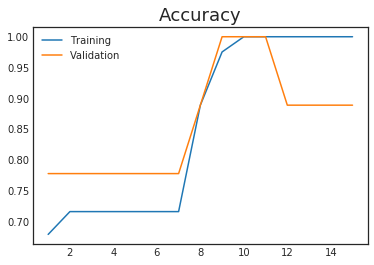

In [11]:
plt.style.use( "seaborn-white" )

plt.title(  "Accuracy", fontsize = 18)

x = range( 1, num_epochs + 1 )
plt.plot( x, history.history[ "acc" ],     label = "Training"   )
plt.plot( x, history.history[ "val_acc" ], label = "Validation" )

legend = plt.legend( loc="upper left" )
plt.show()

In [12]:
test

,message,class_name
70,Hi there,hi
42,Hi cant login today with this err The owners a...,problem
95,jupyter notebook is unable to connect to kernel,problem
78,how do i save my data as a csv file,question
48,Hi I created a csv in my notebook but how do I...,question
79,How do I start using Watson Machine Learning,question
12,hello,hi
59,Hi im having some troubles with a shiny app,problem
10,Hello,hi
14,hello how can i download a csv file from my no...,question


In [13]:
test_results = model.predict_classes( X_test )
print( test_results )

[0 1 1 1 1 1 0 1 0 1]


### Save the model in a .tgz file

In [14]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
model.save( "message-classification-model.h5" )

In [15]:
!tar -zcvf message-classification-model.tgz message-classification-model.h5

message-classification-model.h5


In [16]:
!ls -l

total 416
-rw-r----- 1 dsxuser dsxuser 230928 Jul 19 11:53 message-classification-model.h5
-rw-r----- 1 dsxuser dsxuser 192503 Jul 19 11:53 message-classification-model.tgz


## <a id="step1"></a> Step 2: Store the model in your Watson Machine Learning repository

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=store_model#client.Repository.store_model" target="_blank" rel="noopener noreferrer">store_model</a> function

Paste your Watson Machine Learning credentials in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener noreferrer">Looking up credentials</a>

In [17]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [19]:
# Create a Watson Machine Learning client instance
wml_credentials = {
  "apikey": "IXpAzFjMRpyIhf6tRn4MG1PlRAFFpf4r6JscrzeIaPyX",
  "iam_apikey_description": "Auto-generated for key fd8de7a8-f3c4-40ba-9023-ef63790a06ae",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/bee7bfd322b14a088551c5b943420a03::serviceid:ServiceId-13f24349-680a-4e11-a438-538af5ece89e",
  "instance_id": "9b5542cb-131e-4966-aa69-55984b702532",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [20]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [21]:
metadata = {
    client.repository.ModelMetaNames.NAME: "keras model",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.15",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name": "keras", "version": "2.2.5"}]
}
model_details = client.repository.store_model( model="message-classification-model.tgz", meta_props=metadata )

## <a id="step2"></a> Step 3: Deploy the stored the model in your Watson Machine Learning service

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=deploy#client.Deployments.create" target="_blank" rel="noopener noreferrer">deployments.create</a> function

In [22]:
# Deploy the stored model as an online web service deployment
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras deployment" )



#######################################################################################

Synchronous deployment creation for uid: '44e4d457-c45c-4a1f-af2d-df802abe1e1d' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4c433011-72e3-431b-8f8d-f74b552bd8b7'
------------------------------------------------------------------------------------------------




In [23]:
# Get the deployment UID
deployment_uid = client.deployments.get_uid(deployment_details)
print("Deployment UID: {}".format(deployment_uid))

Deployment UID: 4c433011-72e3-431b-8f8d-f74b552bd8b7


In [26]:
X_test[0]

array([ 3, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [24]:
# Test the deployment
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : X_test.tolist() }
client.deployments.score( model_endpoint_url, payload )

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.6875362396240234, 0.3124637305736542],
   0,
   [0.6875362396240234, 0.3124637305736542]],
  [[0.31205207109451294, 0.6879478693008423],
   1,
   [0.31205207109451294, 0.6879478693008423]],
  [[0.3503628671169281, 0.6496371030807495],
   1,
   [0.3503628671169281, 0.6496371030807495]],
  [[0.29483768343925476, 0.7051622867584229],
   1,
   [0.29483768343925476, 0.7051622867584229]],
  [[0.27285441756248474, 0.7271455526351929],
   1,
   [0.27285441756248474, 0.7271455526351929]],
  [[0.32438692450523376, 0.6756131052970886],
   1,
   [0.32438692450523376, 0.6756131052970886]],
  [[0.7036126852035522, 0.29638734459877014],
   0,
   [0.7036126852035522, 0.29638734459877014]],
  [[0.36457931995391846, 0.6354206204414368],
   1,
   [0.36457931995391846, 0.6354206204414368]],
  [[0.7036126852035522, 0.29638734459877014],
   0,
   [0.7036126852035522, 0.29638734459877014]],
  [[0.27761077880859375, 0.722389280796

## Summary
In this notebook, you imported a Keras model into Watson Machine Learning using the Watson Machine Learning Python client.